# Read JSON files

do premennej `graphs_raw` sa nacitaju vsetky grafy z datasetu

`graph_raw`:
  - `filename`: nazov .lua suboru, z ktoreho je vytvoreny
  - `path`: cesta k .lua suboru, z ktoreho je vytvoreny 
  - `is_test`: 1 ak sa subor nachadzal v `test` adresari, inak 0
  - `is_spec`: 1 ak sa subor nachadzal v `spec` adresari, inak 0
  - `is_shebang`: 1 ak boli prve 2 znaky v subore '#!', inak 0
  - `nodes`: DataFrame(columns=\['id', 'type'\])
  - `edges`: DataFrame(columns=\['from', 'to'\])



In [381]:
import os
import pandas as pd
import json
from tqdm.notebook import tnrange # loading bar

In [382]:
graphs_raw = []

data_path = '../data'
dirs = os.listdir(data_path)
num_dirs = len(dirs)

for i in tnrange(num_dirs, desc='Dataset loading'):
    dirname = dirs[i]
    dir_path = data_path + '/' + dirname
    for filename in os.listdir(dir_path):
        json_file = dir_path + '/' + filename
        with open(json_file) as jf:
            graph = {}
            try:
                json_data = json.load(jf)
                graph['filename'] = json_data['_filename']
                graph['path'] = json_data['_path']
                graph['is_test'] = int(json_data['_isTest'])
                graph['is_spec'] = int(json_data['_isSpec'])
                graph['is_shebang'] = int(json_data['_isShebang'])
                graph['nodes'] = pd.DataFrame(json_data['nodes'], columns=['id', 'type'])
                graph['nodes'] = graph['nodes'].set_index('id')
                graph['edges'] = pd.DataFrame(json_data['edges'], columns=['from', 'to'])
                graphs_raw.append(graph)
            except:
                print(f'Wrong json file: {json_file}')

Dataset loading:   0%|          | 0/216 [00:00<?, ?it/s]

Wrong json file: ../data/cd/simpledraw.lua.json
Wrong json file: ../data/cd-examples/simpledraw.lua.json
Wrong json file: ../data/lrexlib/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib/pcre_sets.lua.json
Wrong json file: ../data/lrexlib-gnu/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib-gnu/pcre_sets.lua.json
Wrong json file: ../data/lrexlib-oniguruma/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib-oniguruma/pcre_sets.lua.json
Wrong json file: ../data/lrexlib-pcre/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib-pcre/pcre_sets.lua.json
Wrong json file: ../data/lrexlib-posix/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib-posix/pcre_sets.lua.json
Wrong json file: ../data/lrexlib-tre/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib-tre/pcre_sets.lua.json
Wrong json file: ../data/lua-openssl/7.csr.lua.json
Wrong json file: ../data/lua-path/test_wcs.lua.json
Wrong json file: ../data/lua-pop3/test-message.lua.json
Wrong json file: ../dat

## Node types

Kedze extraktor, ktory som pouzil na extrakciu grafov zo zdrojovych lua suborov ma nejake bugy, v typoch uzlov sa nachadzaju aj take uzly, ktore by tam byt nemali.

In [383]:
unique_list = []
for d in graphs_raw:
    curr_list = d['nodes']['type'].unique()
    unique_list += list(set(curr_list) - set(unique_list))

In [384]:
print('Node types:')
for u in unique_list:
    print(f'    {u}')

Node types:
    file
    statement:keyword
    blank lines
    module
    statement:while
    interface
    n/a
    function
    global variable
    statement:assign
    variable container
    global function
    require local variable
    require container
    interface container
    statement:localassign
    local variable
    statement:genericfor
    function container
    statement:functioncall
    statement:if
    tableconstructor
    statement:numericfor
    string
    statement:localfunction
    table assign node
    unop
    number
    symbol
    boolean
    statement:repeat
    statement:globalfunction
    keyword
    statement:do
    _prefixexp
    _simpleexp


# OneHot

Kazdemu grafu z `graphs_raw` sa prida atribut `enc_node_types` (OneHot kodovanie typov uzlov).

- `enc_node_types` je DataFrame OneHot kodovani pre vsetky uzly v danom grafe
- **typy uzlov**: *\['require container', 'function', 'local variable', 'file', 'tableconstructor', 'module', 'statement:keyword', 'variable container', 'statement:numericfor', 'statement:genericfor', 'statement:if', 'global function', 'statement:functioncall', 'statement:assign', 'function container', 'statement:localassign', 'global variable', 'statement:globalfunction', 'statement:while', 'statement:localfunction', 'interface container', 'interface', 'require local variable', 'statement:do', 'statement:repeat'\]*
- ostatne typy uzlov sa ignoruju (taketo uzly budu zakodovane samymi nulami)

In [385]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [386]:
node_types = [
    'require container', 'function', 'local variable', 'file', 
    'tableconstructor', 'module', 'statement:keyword', 
    'variable container', 'statement:numericfor', 'statement:genericfor', 
    'statement:if', 'global function', 'statement:functioncall', 
    'statement:assign', 'function container', 'statement:localassign', 
    'global variable', 'statement:globalfunction', 'statement:while', 
    'statement:localfunction', 'interface container', 'interface', 
    'require local variable', 'statement:do', 'statement:repeat'
]

enc = OneHotEncoder(handle_unknown='ignore')
X = np.array(node_types).reshape(-1,1)
enc.fit(X)

for gr in graphs_raw:
    # encode all NodeTypes in graph
    encoded = enc.transform(gr['nodes']['type'].values.reshape(-1,1))
    gr['enc_node_types'] = pd.DataFrame(encoded.toarray())

In [387]:
graphs_raw[0]['enc_node_types']

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create dataset

dataset tvoria `graphs` a `graph_labels`
- `graphs` je numpy.Array of StellarGraphs
- `graph_labels` je numpy.Array oznaceni pre dany graf na i-tej pozcii
    - `basic` => 0
    - `is_shebang` => 1
    - `is_spec` => 2
  
Pozn.: do `basic` zdrojovych kodov som zaradil aj `is_test` (obycajne testy), pretoze struktury ich extrahovanych grafov su velmi podobne

In [388]:
from stellargraph import StellarGraph

In [390]:
def createStellarGraph(graphRaw):
    nodes = graphRaw['enc_node_types']
    edges = graphRaw['edges']
    graph = StellarGraph(nodes=nodes, edges=edges, source_column='from', target_column='to', is_directed=True)
    return graph

graphs = np.array([createStellarGraph(gr) for gr in graphs_raw])
#graph_labels = pd.Series([1 if gr['is_shebang'] else 2 if gr['is_spec'] else 3 if gr['is_test'] else 0 for gr in graphs_raw], dtype="category", name='label')
graph_labels = np.array([1 if gr['is_shebang'] else 2 if gr['is_spec'] else 0 for gr in graphs_raw])

In [391]:
graphs

array([<stellargraph.core.graph.StellarGraph object at 0x7f10ddc69940>,
       ...,
      dtype=object)

In [392]:
graph_labels

array([0, 0, 0, ..., 0, 0, 0])

# Dataset stats

Dataset je velmi nevyvazeny. Pocet `basic` zdrojovych kodov vysoko prevysuje pocty `Shebang` a `Spec` zdrojovych kodov

In [393]:
basic_count, shebang_count, spec_count = pd.Series(graph_labels).value_counts()
print(f'Label counts\n\tBasic: {basic_count}\n\tShebang: {shebang_count}\n\tSpecs: {spec_count}')

Label counts
	Basic: 2249
	Shebang: 131
	Specs: 112


In [394]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,2492.0,2492.0
mean,93.9,156.9
std,165.7,308.6
min,5.0,4.0
25%,20.0,24.0
50%,43.0,57.0
75%,100.0,153.0
max,2400.0,4300.0


# Outliers

Grafy s extremne nizkym (dolny 5% quantil) a s extremne vysokym (horny 5% quantil) poctom uzlov sa z datasetu odfiltruju.

In [395]:
lower = summary['nodes'].quantile(0.05)
upper = summary['nodes'].quantile(0.95)

print(f'Nodes count quantiles:\n    lower: {lower}\n    upper: {upper}')

Nodes count quantiles:
    lower: 8.0
    upper: 341.0


In [396]:
clipped = summary.loc[(summary['nodes'] > lower) & (summary['nodes'] < upper)]

In [397]:
clipped.describe().round(1)

,nodes,edges
count,2239.0,2239.0
mean,68.2,109.6
std,65.9,138.7
min,9.0,8.0
25%,22.5,27.0
50%,43.0,57.0
75%,90.0,136.5
max,340.0,1960.0


In [398]:
graphs = pd.DataFrame(graphs).iloc[clipped.index].to_numpy().flatten()
graph_labels = pd.DataFrame(graph_labels).iloc[clipped.index].to_numpy().flatten()

In [399]:
basic_count, shebang_count, spec_count = pd.Series(graph_labels).value_counts()
print(f'Label counts\n\tBasic: {basic_count}\n\tShebang: {shebang_count}\n\tSpecs: {spec_count}')

Label counts
	Basic: 2028
	Shebang: 122
	Specs: 89


# Undersampling

Z `basic` zdrojovych kodov sa nahodne vyberie mensi pocet grafov ako ich je v skutocnosti, cim sa upravi ich pomer ku grafom ostatnych tried. 

Tymto krokom sa trochu vyvazi dataset.

In [363]:
from imblearn.under_sampling import RandomUnderSampler

In [400]:
u_samp_strategy = {
    0: 200,
    1: shebang_count,
    2: spec_count
}

undersample = RandomUnderSampler(sampling_strategy=u_samp_strategy, random_state=1)
graphs_under, graph_labels_under = undersample.fit_resample(graphs.reshape(-1, 1), graph_labels)

In [401]:
graphs = graphs_under.flatten()
graph_labels = graph_labels_under

# Final (sampled) dataset stats

In [402]:
print(graphs[0].info())

StellarGraph: Directed multigraph
 Nodes: 11, Edges: 10

 Node types:
  default: [11]
    Features: float32 vector, length 25
    Edge types: default-default->default

 Edge types:
    default-default->default: [10]
        Weights: all 1 (default)
        Features: none


In [403]:
print(graphs[1].info())

StellarGraph: Directed multigraph
 Nodes: 18, Edges: 69

 Node types:
  default: [18]
    Features: float32 vector, length 25
    Edge types: default-default->default

 Edge types:
    default-default->default: [69]
        Weights: all 1 (default)
        Features: none


In [404]:
basic_count, shebang_count, spec_count = pd.Series(graph_labels).value_counts()
print(f'Label counts\n\tBasic: {basic_count}\n\tShebang: {shebang_count}\n\tSpecs: {spec_count}')

Label counts
	Basic: 200
	Shebang: 122
	Specs: 89


In [405]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,411.0,411.0
mean,67.5,136.0
std,69.8,200.3
min,9.0,8.0
25%,22.5,28.0
50%,40.0,58.0
75%,83.0,151.5
max,329.0,1960.0


# Prepair generator
Z `graph_labels` sa vytvori OneHot encoding labelov. 

Pozn.: Generator je potrebny neskor na to, aby sa objekty typu `StellarGraph` mohli vkladat do modelu neuronovej siete z Tensorflow-u

In [406]:
from stellargraph.mapper import PaddedGraphGenerator

In [407]:
graph_labels = pd.get_dummies(graph_labels, drop_first=False)

print(graph_labels)

     0  1  2
0    1  0  0
1    1  0  0
2    1  0  0
3    1  0  0
4    1  0  0
..  .. .. ..
406  0  0  1
407  0  0  1
408  0  0  1
409  0  0  1
410  0  0  1

[411 rows x 3 columns]


In [408]:
num_graphs, num_classes = graph_labels.shape

print(f'Number of classes: {num_classes}\nNumber of graphs: {num_graphs}')

Number of classes: 3
Number of graphs: 411


In [409]:
generator = PaddedGraphGenerator(graphs=graphs)

# Supervised graph classification with GCN [StellarGraph]

In [410]:
import stellargraph as sg
from stellargraph.layer import GCNSupervisedGraphClassification
from sklearn import model_selection
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

## Split dataset to TRAIN, VALIDATION and TEST
Pomer percent TRENOVACI\:VALIDACNY\:TESTOVACI == **70\:15\:15**

In [411]:
# TRAIN:TEST 85:15
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.85, test_size=None, stratify=graph_labels
)

# TRAIN:VALIDATION 82.4:17.6 => 85*0.824 == 70  85*0.176 == 15 
train_graphs, val_graphs = model_selection.train_test_split(
    train_graphs, train_size=0.824, test_size=None
)

In [431]:
print(f'TRAIN graphs: {len(train_graphs)}\nVALIDATION graphs: {len(val_graphs)}\nTEST graphs: {len(test_graphs)}')

TRAIN graphs: 287
VALIDATION graphs: 62
TEST graphs: 62


## Create generators

In [413]:
batch_size=20

train_gen = generator.flow(
        train_graphs.index, targets=graph_labels.iloc[train_graphs.index].values, batch_size=batch_size
    )
val_gen = generator.flow(
        val_graphs.index, targets=graph_labels.iloc[val_graphs.index].values, batch_size=batch_size
    )

## Create model
Model ma spolu 11 vrstiev (aj s dropout vrstvami).

In [414]:
gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )

x_inp, x_out = gc_model.in_out_tensors()
predictions = Dense(units=32, activation="relu")(x_out)
predictions = Dense(units=16, activation="relu")(predictions)
predictions = Dense(num_classes, activation="softmax")(predictions)

model = Model(inputs=x_inp, outputs=predictions)
model.compile(optimizer=Adam(0.005), loss=categorical_crossentropy, metrics=["acc"])

## Train model

In [415]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [432]:
epochs = 100

In [416]:
history = model.fit(
        train_gen, epochs=epochs, validation_data=val_gen, verbose=1, callbacks=[es],
    )

Epoch 1/100
15/15 [==============================] - 2s 86ms/step - loss: 1.0638 - acc: 0.4897 - val_loss: 0.9789 - val_acc: 0.4677
Epoch 2/100
15/15 [==============================] - 1s 35ms/step - loss: 0.9401 - acc: 0.5323 - val_loss: 0.8182 - val_acc: 0.6129
Epoch 3/100
15/15 [==============================] - 0s 32ms/step - loss: 0.8257 - acc: 0.6430 - val_loss: 0.7905 - val_acc: 0.6935
Epoch 4/100
15/15 [==============================] - 0s 30ms/step - loss: 0.7009 - acc: 0.7271 - val_loss: 0.6603 - val_acc: 0.7581
Epoch 5/100
15/15 [==============================] - 1s 35ms/step - loss: 0.6538 - acc: 0.6977 - val_loss: 0.7502 - val_acc: 0.7097
Epoch 6/100
15/15 [==============================] - 0s 29ms/step - loss: 0.6376 - acc: 0.7355 - val_loss: 0.6071 - val_acc: 0.7903
Epoch 7/100
15/15 [==============================] - 0s 31ms/step - loss: 0.6641 - acc: 0.7234 - val_loss: 0.5720 - val_acc: 0.8226
Epoch 8/100
15/15 [==============================] - 0s 31ms/step - loss: 0.

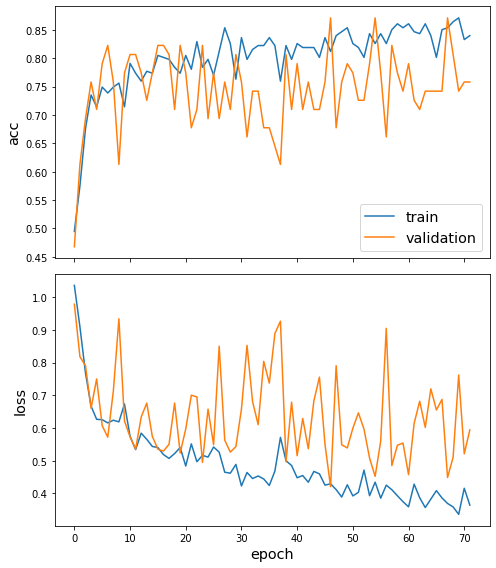

In [417]:
sg.utils.plot_history(history)

# Evaluate on test sample

In [418]:
test_gen = generator.flow(
        test_graphs.index, targets=graph_labels.iloc[test_graphs.index].values, batch_size=1
    )

In [419]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

62/62 [==============================] - 0s 2ms/step - loss: 0.3987 - acc: 0.8387

Test Set Metrics:
	loss: 0.3987
	acc: 0.8387


# Visualize predictions

In [433]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [434]:
predicts = model.predict(test_gen)
Y_pred = predicts.argmax(axis=1)
Y = graph_labels.iloc[test_graphs.index].values.argmax(axis=1)
cf_matrix = confusion_matrix(Y, Y_pred)

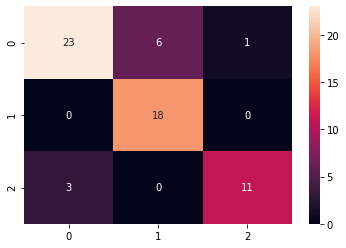

In [436]:
_ = sns.heatmap(cf_matrix, annot=True)

In [425]:
res['basic'] = predicts[:,0]
res['shebang'] = predicts[:,1] 
res['spec'] = predicts[:,2]

<ipython-input-426-6d85375d06cf>:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(10,10)).gca(projection='3d')


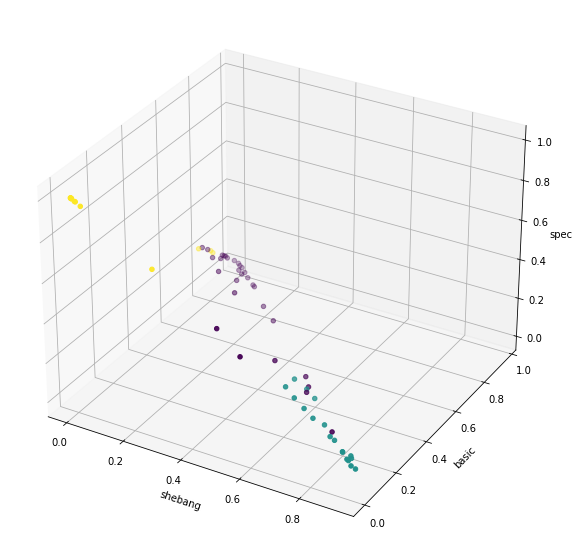

In [426]:
ax = plt.figure(figsize=(10,10)).gca(projection='3d')
ax.scatter(
    xs=res["shebang"], 
    ys=res["basic"], 
    zs=res["spec"], 
    c=Y
)
ax.set_xlabel('shebang')
ax.set_ylabel('basic')
ax.set_zlabel('spec')
plt.show()

# Save model to local storage

In [252]:
model.save('model')

INFO:tensorflow:Assets written to: model_3classes_undersample/assets
